<a href="https://colab.research.google.com/github/Viraj465/Gen-AI-Breast-Cancer-detection/blob/main/__GENAI_BreastCancerNotebook__.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Gemini install
!pip install -q -U python-gemini-api pillow

In [ ]:
import google.generativeai as genai
from google.colab import userdata

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)

gen_model = genai.GenerativeModel('gemini-1.5-flash')

In [1]:
!nvidia-smi

Mon Sep 30 07:00:54 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
print('built with cuda',tf.test.is_built_with_cuda(), '\n',
'gpus available',tf.test.is_gpu_available())

gpus = tf.config.list_physical_devices('GPU')
cpus = tf.config.list_physical_devices('CPU')

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


built with cuda True 
 gpus available True


In [1]:
import re
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "2"
import glob
import json
import requests
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style = "whitegrid")
import tensorflow as tf
import tf_keras
from tf_keras.models import Sequential, Model, save_model, load_model
from tf_keras.layers import (Dense, Dropout, Activation, MaxPool2D, Flatten, Conv2D, UpSampling2D, Input,
                             Conv2DTranspose, LeakyReLU, BatchNormalization, Reshape,Input)
from tf_keras.optimizers import Adam, RMSprop
from tf_keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from tf_keras.losses import categorical_crossentropy, sparse_categorical_crossentropy
from tf_keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard
from tf_keras.utils import to_categorical
from tf_keras.preprocessing.image import img_to_array, load_img
from tf_keras.activations import relu, sigmoid, tanh, softmax
from google.colab.patches import cv2_imshow
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

np.random.seed(42)
tf.random.set_seed(42)

import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
image_xlsx_data = r'/content/drive/MyDrive/__GENAIXCHANGE__/brest-lesion-dataset.xlsx'
norm_image_folder=r'/content/drive/MyDrive/__GENAIXCHANGE__/norm_grayscale_folder'
tumor_image_folder = r'/content/drive/MyDrive/__GENAIXCHANGE__/new_tumor_folder'
csv_data = pd.read_excel(image_xlsx_data)
len(os.listdir(norm_image_folder)), len(os.listdir(tumor_image_folder))

(256, 252)

In [4]:
csv_data.head()

,Image_filename,Mask_tumor_filename,thermogramImages,roiImages,normal_image_path,Pixel_size,Age,Tissue_composition,Signs,Symptoms,Shape,Margin,Echogenicity,Posterior_features,Halo,Calcifications,Skin_thickening,Interpretation,Verification,Diagnosis,BIRADS,Classification
0,case001.png,case001_tumor.png,thermogram_case001.png,output_thermogram_case001.png,/content/drive/MyDrive/__GENAIXCHANGE__/norm_g...,0.007812,57,heterogeneous: predominantly fat,breast scar,family history of breast/ovarian cancer,irregular,not circumscribed - indistinct,heterogeneous,shadowing,no,no,yes,Breast scar (surgery)&Breast scar (radiotherapy),confirmed by follow-up care,not applicable,2.0,benign
1,case002.png,case002_tumor.png,thermogram_case002.png,output_thermogram_case002.png,/content/drive/MyDrive/__GENAIXCHANGE__/norm_g...,0.006462,53,homogeneous: fat,not available,not available,oval,not circumscribed - indistinct,hypoechoic,no,no,no,no,Dysplasia&Fibroadenoma,confirmed by biopsy,Intramammary lymph node,4.2,benign
2,case003.png,case003_tumor.png,thermogram_case003.png,output_thermogram_case003.png,/content/drive/MyDrive/__GENAIXCHANGE__/norm_g...,0.006944,56,heterogeneous: predominantly fat,no,nipple discharge,oval,circumscribed,hyperechoic,no,no,no,no,Duct filled with thick fluid&Intraductal papil...,confirmed by biopsy,Usual ductal hyperplasia (UDH)&Pseudoangiomato...,4.1,benign
3,case004.png,case004_tumor.png,thermogram_case004.png,output_thermogram_case004.png,/content/drive/MyDrive/__GENAIXCHANGE__/norm_g...,0.007812,43,homogeneous: fibroglandular,no,no,round,circumscribed,hypoechoic,no,no,no,no,Cyst filled with thick fluid,confirmed by follow-up care,not applicable,3.0,benign
4,case005.png,case005_tumor.png,thermogram_case005.png,output_thermogram_case005.png,/content/drive/MyDrive/__GENAIXCHANGE__/norm_g...,0.007812,67,homogeneous: fat,nipple retraction&palpable,family history of breast/ovarian cancer,oval,circumscribed,complex cystic/solid,enhancement,no,no,no,Suspicion of malignancy&Intraductal papilloma,confirmed by biopsy,Encapsulated papillary carcinoma&Ductal carcin...,4.2,malignant


<font color="yellow"> The color in yellow depicts features can be imp for early-stage detection</font><br>
1.   <font color="yellow">Tissue_composition</font>: This refers to the composition of tissues in the tumor region, which can help in understanding the nature of the tumor (e.g., benign vs malignant)
2.   <font color="yellow">Signs</font>: Any clinical signs (like lumps) can be relevant to **early-stage** detection
3. *Symptoms: Symptoms can give clues regarding the progression or aggressiveness of the cancer.* (need to reconsider if to keep or not)
4. <font color="yellow">Shape</font>: The shape of a tumor can be an important diagnostic feature. Irregularly shaped tumors may indicate malignancy.
5. <font color="yellow">Margin</font>: This describes the border of the tumor. A smooth margin is more likely benign, while a spiculated or irregular margin may indicate malignancy.
6. <font color="yellow">Echogenicity</font>: This refers to the ability of the tissue to reflect ultrasound waves, which can be useful in distinguishing between benign and malignant masses.
7. *Posterior_features: These features (e.g., shadowing or enhancement) provide additional clues about the type of mass*
8. *Halo: Presence or absence of a halo around the tumor may help in determining malignancy.*
9. <font color="yellow">Calcifications</font>: Microcalcifications are tiny deposits of calcium that may indicate **early-stage cancer**, especially in mammograms.*
10. <font color="yellow">Skin_thickening</font>: This can be an early sign of malignancy, particularly in breast cancer*
11. <font color="pink">BIRADS</font>: This is a standardized breast imaging reporting system used by radiologists. A lower BIRADS score indicates likely benign findings, while a higher score is more suspicious of cancer.
12. *Interpretation: The interpretation of the imaging study could provide insights into early-stage vs later-stage cancer.*
13. *Diagnosis: If available, this column could provide definitive information about whether the tumor is cancerous and its stage.*



In [5]:
csv_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Image_filename       256 non-null    object 
 1   Mask_tumor_filename  256 non-null    object 
 2   thermogramImages     256 non-null    object 
 3   roiImages            256 non-null    object 
 4   normal_image_path    256 non-null    object 
 5   Pixel_size           256 non-null    float64
 6   Age                  256 non-null    int64  
 7   Tissue_composition   256 non-null    object 
 8   Signs                256 non-null    object 
 9   Symptoms             256 non-null    object 
 10  Shape                256 non-null    object 
 11  Margin               256 non-null    object 
 12  Echogenicity         256 non-null    object 
 13  Posterior_features   256 non-null    object 
 14  Halo                 256 non-null    object 
 15  Calcifications       256 non-null    obj

# <font color="yellow">**Image processing code**</font>

In [6]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
CHANNEL = 1 # most important part
LATENT_DIM = 128
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH,CHANNEL)
BATCH_SIZE = 16
LR = 1e-3

In [7]:
images = []

for img_name in sorted(os.listdir(norm_image_folder)):
    img_path = os.path.join(norm_image_folder, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = img / 255
    images.append(img)

In [8]:
images = np.array(images)
images = images.reshape(-1, IMG_HEIGHT, IMG_WIDTH, CHANNEL)
images.shape

(256, 224, 224, 1)

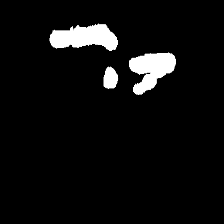

In [9]:
main_mask_path = tumor_image_folder + "/case140_tumor.png"
cv2_imshow(cv2.imread(main_mask_path, cv2.IMREAD_GRAYSCALE))

**Code to combine multiple mask images into one.**

In [10]:
# new_tumor_image_folder = r'/content/drive/MyDrive/__GENAIXCHANGE__/new_tumor_folder'
# if not os.path.exists(new_tumor_image_folder):
#     os.makedirs(new_tumor_image_folder)

# main_mask_files = glob.glob(tumor_image_folder + '/*_tumor.png')
# other_mask_path = []
# for main_mask_path in main_mask_files:
#     base_name = os.path.basename(main_mask_path).replace('_tumor.png', '')
#     mask_files = glob.glob(tumor_image_folder + '/' + base_name + '_other*.png')
#     other_mask_path.append(mask_files)
#     main_mask = cv2.imread(main_mask_path, cv2.IMREAD_GRAYSCALE)
#     combined_mask = main_mask.copy()
#     for mask_path in mask_files:
#         mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
#         combined_mask = cv2.bitwise_or(combined_mask, mask)
#     combined_mask_path = new_tumor_image_folder + '/' + base_name + '_tumor.png'
#     cv2.imwrite(combined_mask_path, combined_mask)
#     print(f"Combined mask saved to: {combined_mask_path}")

In [11]:
mask_paths = []
filtered_image_paths = []
for index, row in csv_data.iterrows():
  if row['Classification'] in ['benign', 'malignant']:
    image_name = row['Mask_tumor_filename']
    masks_for_image = [os.path.join(tumor_image_folder, mask_name) for mask_name in os.listdir(tumor_image_folder) if mask_name.startswith(image_name)]

    if masks_for_image:
      mask_paths.append(masks_for_image)

      filtered_image_paths.append(os.path.join(norm_image_folder,row['Image_filename']))


In [12]:
len(mask_paths), len(filtered_image_paths)

(252, 252)

In [13]:
input_shape = Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNEL))
# Encoder
x = input_shape
print(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = MaxPool2D((2, 2))(x)  # 112

x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = MaxPool2D((2, 2))(x)  # 56

x = Conv2D(128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = MaxPool2D((2, 2))(x)  # 28

x = Conv2D(256, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = MaxPool2D((2, 2))(x)  # 14

x = Conv2D(512, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
encoded = MaxPool2D((2, 2))(x)  # 7
print(encoded)
x = Flatten()(encoded)
units = x.shape[1]
latent_dim = 10
latent = Dense(LATENT_DIM, name='Latent')(x)

# Decoder
x = Dense(units)(latent)
x = LeakyReLU(alpha=0.2)(x)
x = Reshape((7, 7, 512))(x)

x = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('sigmoid')(x)
decoded = Conv2DTranspose(CHANNEL, (3, 3), strides=(1, 1), padding='same')(x)

outputs = decoded
print(outputs)

KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 512), dtype=tf.float32, name=None), name='max_pooling2d_4/MaxPool:0', description="created by layer 'max_pooling2d_4'")
KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None), name='conv2d_transpose_5/BiasAdd:0', description="created by layer 'conv2d_transpose_5'")


In [14]:
autoencoder = Model(input_shape, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [15]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    ModelCheckpoint(filepath='/content/drive/MyDrive/__GENAIXCHANGE__/autoencoder_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

In [16]:
autoencoder.fit(images,images, epochs=100, batch_size=BATCH_SIZE, validation_split=0.1,verbose = 2, callbacks = callbacks)

Epoch 1/100

Epoch 1: val_loss improved from inf to 4.32006, saving model to /content/drive/MyDrive/__GENAIXCHANGE__/autoencoder_model.h5
15/15 - 29s - loss: 3.9701 - val_loss: 4.3201 - lr: 0.0010 - 29s/epoch - 2s/step
Epoch 2/100

Epoch 2: val_loss did not improve from 4.32006
15/15 - 2s - loss: 3.9366 - val_loss: 4.3201 - lr: 0.0010 - 2s/epoch - 112ms/step
Epoch 3/100

Epoch 3: val_loss did not improve from 4.32006
15/15 - 2s - loss: 3.9148 - val_loss: 4.3201 - lr: 0.0010 - 2s/epoch - 113ms/step
Epoch 4/100

Epoch 4: val_loss did not improve from 4.32006
15/15 - 2s - loss: 3.8649 - val_loss: 4.3201 - lr: 0.0010 - 2s/epoch - 108ms/step
Epoch 5/100

Epoch 5: val_loss improved from 4.32006 to 4.31999, saving model to /content/drive/MyDrive/__GENAIXCHANGE__/autoencoder_model.h5
15/15 - 2s - loss: 3.6604 - val_loss: 4.3200 - lr: 0.0010 - 2s/epoch - 154ms/step
Epoch 6/100

Epoch 6: val_loss improved from 4.31999 to 3.94120, saving model to /content/drive/MyDrive/__GENAIXCHANGE__/autoencode

In [17]:
trained_encoder = Model(input_shape, encoded)

In [18]:
image_features = trained_encoder.predict(images)

8/8 [==============================] - 1s 24ms/step


In [19]:
image_features.shape

(256, 7, 7, 512)

**<font color = "orange">SegNet</font>**

In [20]:
masks = []
for mask_name in filtered_image_paths:
    mask_path = os.path.join(tumor_image_folder, mask_name)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = mask / 255
    masks.append(mask)

In [21]:
masks_array = np.array(masks)
masks_array = masks_array.reshape(-1, IMG_HEIGHT, IMG_WIDTH, CHANNEL)
masks_array.shape

(252, 224, 224, 1)

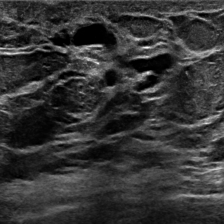

In [22]:
cv2_imshow(cv2.imread("/content/drive/MyDrive/__GENAIXCHANGE__/norm_grayscale_folder/case140.png"))

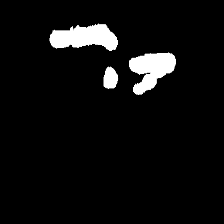

In [23]:
cv2_imshow(cv2.imread("/content/drive/MyDrive/__GENAIXCHANGE__/new_tumor_folder/case140_tumor.png"))

In [24]:
mask_paths = [filename for sublist in mask_paths for filename in sublist]

In [25]:
mask_paths[0]

'/content/drive/MyDrive/__GENAIXCHANGE__/new_tumor_folder/case001_tumor.png'

In [26]:
tumor_masks = []
for mask in mask_paths:
    tumor_mask_path = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)
    tumor_mask_path = tumor_mask_path / 255
    tumor_masks.append(tumor_mask_path)

In [27]:
tumor_masks = np.array(tumor_masks)
tumor_masks = tumor_masks.reshape(-1, IMG_HEIGHT, IMG_WIDTH, CHANNEL)
tumor_masks.shape

(252, 224, 224, 1)

In [28]:
def build_segnet(input_shape):
    inputs = Input(shape=input_shape)
    print(inputs)

    # Encoder
    x = Conv2D(32, (3, 3), activation=tf_keras.layers.LeakyReLU(alpha=0.02), padding='same')(inputs)
    x = MaxPool2D((2, 2), padding='same')(x) #112
    x = Conv2D(64, (3, 3), activation=tf_keras.layers.LeakyReLU(alpha=0.02), padding='same')(x)
    x = MaxPool2D((2, 2), padding='same')(x) #56
    x = Conv2D(128, (3, 3), activation=tf_keras.layers.LeakyReLU(alpha=0.02), padding='same')(x)
    x = MaxPool2D((2, 2), padding='same')(x) #28
    x = Conv2D(256, (3, 3), activation=tf_keras.layers.LeakyReLU(alpha=0.02), padding='same')(x)
    x = MaxPool2D((2, 2), padding='same')(x) #14
    x = Conv2D(512, (3, 3), activation=tf_keras.layers.LeakyReLU(alpha=0.02), padding='same')(x)
    x = MaxPool2D((2, 2), padding='same')(x) #7
    print(x)
    # Decoder
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(512, (3, 3), activation=tf_keras.layers.LeakyReLU(alpha=0.02), padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation=tf_keras.layers.LeakyReLU(alpha=0.02), padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation=tf_keras.layers.LeakyReLU(alpha=0.02), padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation=tf_keras.layers.LeakyReLU(alpha=0.02), padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation=tf_keras.layers.LeakyReLU(alpha=0.02), padding='same')(x)
    print(x)

    outputs = Conv2D(CHANNEL, (3, 3), activation='sigmoid', padding='same')(x)
    print(outputs)

    model = Model(inputs, outputs)
    return model

In [29]:
segnet = build_segnet(INPUT_SHAPE)

KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 512), dtype=tf.float32, name=None), name='max_pooling2d_9/MaxPool:0', description="created by layer 'max_pooling2d_9'")
KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 32), dtype=tf.float32, name=None), name='conv2d_14/leaky_re_lu_19/LeakyRelu:0', description="created by layer 'conv2d_14'")
KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None), name='conv2d_15/Sigmoid:0', description="created by layer 'conv2d_15'")


In [30]:
segnet.compile(optimizer='adam', loss='binary_crossentropy')

In [31]:
segnet_callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    ModelCheckpoint(filepath='/content/drive/MyDrive/__GENAIXCHANGE__/segnet_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

In [32]:
segnet.fit(masks_array, tumor_masks, epochs=100, batch_size=BATCH_SIZE, validation_split=0.1, verbose=2, callbacks=segnet_callbacks)

Epoch 1/100

Epoch 1: val_loss improved from inf to 0.32731, saving model to /content/drive/MyDrive/__GENAIXCHANGE__/segnet_model.h5
15/15 - 15s - loss: 0.7128 - val_loss: 0.3273 - lr: 0.0010 - 15s/epoch - 995ms/step
Epoch 2/100

Epoch 2: val_loss improved from 0.32731 to 0.32465, saving model to /content/drive/MyDrive/__GENAIXCHANGE__/segnet_model.h5
15/15 - 2s - loss: 0.3148 - val_loss: 0.3246 - lr: 0.0010 - 2s/epoch - 163ms/step
Epoch 3/100

Epoch 3: val_loss improved from 0.32465 to 0.27849, saving model to /content/drive/MyDrive/__GENAIXCHANGE__/segnet_model.h5
15/15 - 2s - loss: 0.2849 - val_loss: 0.2785 - lr: 0.0010 - 2s/epoch - 152ms/step
Epoch 4/100

Epoch 4: val_loss improved from 0.27849 to 0.21798, saving model to /content/drive/MyDrive/__GENAIXCHANGE__/segnet_model.h5
15/15 - 2s - loss: 0.2343 - val_loss: 0.2180 - lr: 0.0010 - 2s/epoch - 154ms/step
Epoch 5/100

Epoch 5: val_loss did not improve from 0.21798
15/15 - 2s - loss: 0.2302 - val_loss: 0.2697 - lr: 0.0010 - 2s/epo

In [33]:
segnet_predicted_masks = segnet.predict(masks_array)
segnet_predicted_masks

8/8 [==============================] - 6s 436ms/step


array([[[[5.89485886e-03],
         [7.89100071e-04],
         [3.32607422e-04],
         ...,
         [1.26367901e-04],
         [2.64637696e-04],
         [3.10235168e-03]],

        [[2.80829100e-03],
         [7.26401282e-04],
         [5.80232125e-04],
         ...,
         [7.77536479e-05],
         [1.11283931e-04],
         [6.92215748e-04]],

        [[5.24912728e-04],
         [1.81154479e-04],
         [3.13262048e-04],
         ...,
         [1.01591861e-04],
         [1.34095229e-04],
         [7.62286596e-04]],

        ...,

        [[2.02048323e-04],
         [3.02687954e-06],
         [6.61504487e-07],
         ...,
         [1.41192717e-11],
         [1.46827150e-09],
         [4.16371876e-07]],

        [[5.41073736e-04],
         [1.79050930e-05],
         [3.52710094e-06],
         ...,
         [1.52892599e-09],
         [1.66234031e-07],
         [2.43466434e-06]],

        [[2.88130133e-03],
         [1.32317045e-05],
         [1.67944620e-06],
         ...,
 

In [36]:
segnet_predicted_masks.shape

(252, 224, 224, 1)

In [37]:
predicted_masks = segnet.predict(images)
predicted_masks

8/8 [==============================] - 1s 91ms/step


array([[[[5.89485886e-03],
         [7.89100071e-04],
         [3.32607422e-04],
         ...,
         [1.26367901e-04],
         [2.64637696e-04],
         [3.10235168e-03]],

        [[2.80829100e-03],
         [7.26401282e-04],
         [5.80232125e-04],
         ...,
         [7.77536479e-05],
         [1.11283931e-04],
         [6.92215748e-04]],

        [[5.24912728e-04],
         [1.81154479e-04],
         [3.13262048e-04],
         ...,
         [1.01591861e-04],
         [1.34095229e-04],
         [7.62286596e-04]],

        ...,

        [[2.02048323e-04],
         [3.02687954e-06],
         [6.61504487e-07],
         ...,
         [1.41192717e-11],
         [1.46827150e-09],
         [4.16371876e-07]],

        [[5.41073736e-04],
         [1.79050930e-05],
         [3.52710094e-06],
         ...,
         [1.52892599e-09],
         [1.66234031e-07],
         [2.43466434e-06]],

        [[2.88130133e-03],
         [1.32317045e-05],
         [1.67944620e-06],
         ...,
 

In [39]:
predicted_masks.shape

(256, 224, 224, 1)

# <font color = "orange">**CSV Data processing**</font>

<font color = "orange">**BIRADS and Classification**</font>

In [86]:
!pip install lightgbm

In [88]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, accuracy_score

In [89]:
gen_cols = ['Tissue_composition', 'Signs', 'Shape', 'Margin', 'Echogenicity', 'Calcifications']
categorical_cols = ['Tissue_composition', 'Signs', 'Symptoms', 'Shape', 'Margin',
                    'Echogenicity', 'Posterior_features', 'Halo','Diagnosis', 'Calcifications',
                    'Skin_thickening', 'Interpretation', 'Verification']
numerical_cols = ['BIRADS','Age','Pixel_size']

In [42]:
csv_data.drop(columns=['roiImages','thermogramImages','normal_image_path'],axis = 1, inplace=True)

In [90]:
csv_data[:2]

,Image_filename,Mask_tumor_filename,Pixel_size,Age,Tissue_composition,Signs,Symptoms,Shape,Margin,Echogenicity,Posterior_features,Halo,Calcifications,Skin_thickening,Interpretation,Verification,Diagnosis,BIRADS,Classification
0,case001.png,case001_tumor.png,0.007812,57,heterogeneous: predominantly fat,breast scar,family history of breast/ovarian cancer,irregular,not circumscribed - indistinct,heterogeneous,shadowing,no,no,yes,Breast scar (surgery)&Breast scar (radiotherapy),confirmed by follow-up care,not applicable,2.0,benign
1,case002.png,case002_tumor.png,0.006462,53,homogeneous: fat,not available,not available,oval,not circumscribed - indistinct,hypoechoic,no,no,no,no,Dysplasia&Fibroadenoma,confirmed by biopsy,Intramammary lymph node,4.2,benign


In [45]:
csv_data_encoded = pd.get_dummies(csv_data, columns=categorical_cols)

In [91]:
csv_data_encoded[:2]

,Image_filename,Mask_tumor_filename,Pixel_size,Age,BIRADS,Classification,Tissue_composition_heterogeneous: predominantly fat,Tissue_composition_heterogeneous: predominantly fibroglandular,Tissue_composition_homogeneous: fat,Tissue_composition_homogeneous: fibroglandular,Tissue_composition_lactating,Tissue_composition_lactating&heterogeneous: predominantly fat,Tissue_composition_lactating&heterogeneous: predominantly fibroglandular,Tissue_composition_lactating&homogeneous: fibroglandular,Tissue_composition_not available,Signs_breast scar,Signs_breast scar&skin retraction,Signs_nipple retraction,Signs_nipple retraction&palpable,Signs_no,Signs_not available,Signs_palpable,Signs_palpable&breast scar,Signs_peau d`orange&palpable,Signs_redness&warmth,Signs_redness&warmth&palpable,Signs_skin retraction&palpable,Signs_warmth&palpable,Symptoms_HRT/hormonal contraception,Symptoms_breast injury,Symptoms_family history of breast/ovarian cancer,Symptoms_family history of breast/ovarian cancer&HRT/hormonal contraception,Symptoms_nipple discharge,Symptoms_nipple discharge&family history of breast/ovarian cancer,Symptoms_no,Symptoms_not available,Symptoms_personal history of breast cancer,Symptoms_personal history of breast cancer&family history of breast/ovarian cancer,Shape_irregular,Shape_not applicable,Shape_oval,Shape_round,Margin_circumscribed,Margin_not applicable,Margin_not circumscribed - angular,Margin_not circumscribed - angular&indistinct,Margin_not circumscribed - angular&microlobulated,Margin_not circumscribed - angular&microlobulated&indistinct,Margin_not circumscribed - indistinct,Margin_not circumscribed - microlobulated,Margin_not circumscribed - microlobulated&indistinct,Margin_not circumscribed - spiculated,Margin_not circumscribed - spiculated&angular,Margin_not circumscribed - spiculated&angular&indistinct,Margin_not circumscribed - spiculated&angular&microlobulated&indistinct,Margin_not circumscribed - spiculated&indistinct,Margin_not circumscribed - spiculated&microlobulated&indistinct,Echogenicity_anechoic,Echogenicity_complex cystic/solid,Echogenicity_heterogeneous,Echogenicity_hyperechoic,Echogenicity_hypoechoic,Echogenicity_isoechoic,Echogenicity_not applicable,Posterior_features_combined,Posterior_features_enhancement,Posterior_features_no,Posterior_features_not applicable,Posterior_features_shadowing,Halo_no,Halo_not applicable,Halo_yes,Diagnosis_Atypical lobular hyperplasia (ALH),Diagnosis_Benign mammary dysplasia,Diagnosis_Benign mammary dysplasia&Usual ductal hyperplasia (UDH),Diagnosis_Complex sclerosing lesion,Diagnosis_Cribriform carcinoma,Diagnosis_Ductal carcinoma in situ (DCIS),Diagnosis_Ductal carcinoma in situ (DCIS)&Invasive carcinoma of no special type (NST),Diagnosis_Ductal carcinoma in situ (DCIS)&Solid papillary carcinoma in situ,Diagnosis_Encapsulated papillary carcinoma&Ductal carcinoma in situ (DCIS),Diagnosis_Fat necrosis,Diagnosis_Fibroadenoma,Diagnosis_Fibroadenoma&Phyllodes tumor,Diagnosis_Fibroadenosis,Diagnosis_Fibrocystic change,Diagnosis_Fibrosclerosis,Diagnosis_Hamartoma,Diagnosis_Intraductal papilloma,Diagnosis_Intraductal papilloma&Usual ductal hyperplasia (UDH)&Adenosis,Diagnosis_Intramammary lymph node,Diagnosis_Invasive carcinoma of no special type (NST),Diagnosis_Invasive carcinoma of no special type (NST)&Apocrine carcinoma,Diagnosis_Invasive carcinoma of no special type (NST)&Ductal carcinoma in situ (DCIS),Diagnosis_Invasive carcinoma of no special type (NST)&Invasive micropapillary carcinoma,Diagnosis_Invasive carcinoma of no special type (NST)&Mucinous carcinoma,Diagnosis_Invasive carcinoma of no special type (NST)&Sebaceous carcinoma,Diagnosis_Invasive lobular carcinoma,Diagnosis_Invasive lobular carcinoma&Lobular carcinoma in situ (LCIS),Diagnosis_Invasive micropapillary carcinoma,Diagnosis_Invasive papillary carcinoma&Encapsulated papillary carcinoma,Diagnosis_Lactating adenoma,Diagnosis_Lobular carcinoma in situ (LCIS),Diagnosis_Lymphoma,Diagnosis_Mastitis,Diagnosis_Meta

In [92]:
csv_features = csv_data_encoded.drop(['Image_filename', 'Mask_tumor_filename',
                                      'BIRADS', 'Classification'], axis=1)

In [93]:
csv_features[:5]

,Pixel_size,Age,Tissue_composition_heterogeneous: predominantly fat,Tissue_composition_heterogeneous: predominantly fibroglandular,Tissue_composition_homogeneous: fat,Tissue_composition_homogeneous: fibroglandular,Tissue_composition_lactating,Tissue_composition_lactating&heterogeneous: predominantly fat,Tissue_composition_lactating&heterogeneous: predominantly fibroglandular,Tissue_composition_lactating&homogeneous: fibroglandular,Tissue_composition_not available,Signs_breast scar,Signs_breast scar&skin retraction,Signs_nipple retraction,Signs_nipple retraction&palpable,Signs_no,Signs_not available,Signs_palpable,Signs_palpable&breast scar,Signs_peau d`orange&palpable,Signs_redness&warmth,Signs_redness&warmth&palpable,Signs_skin retraction&palpable,Signs_warmth&palpable,Symptoms_HRT/hormonal contraception,Symptoms_breast injury,Symptoms_family history of breast/ovarian cancer,Symptoms_family history of breast/ovarian cancer&HRT/hormonal contraception,Symptoms_nipple discharge,Symptoms_nipple discharge&family history of breast/ovarian cancer,Symptoms_no,Symptoms_not available,Symptoms_personal history of breast cancer,Symptoms_personal history of breast cancer&family history of breast/ovarian cancer,Shape_irregular,Shape_not applicable,Shape_oval,Shape_round,Margin_circumscribed,Margin_not applicable,Margin_not circumscribed - angular,Margin_not circumscribed - angular&indistinct,Margin_not circumscribed - angular&microlobulated,Margin_not circumscribed - angular&microlobulated&indistinct,Margin_not circumscribed - indistinct,Margin_not circumscribed - microlobulated,Margin_not circumscribed - microlobulated&indistinct,Margin_not circumscribed - spiculated,Margin_not circumscribed - spiculated&angular,Margin_not circumscribed - spiculated&angular&indistinct,Margin_not circumscribed - spiculated&angular&microlobulated&indistinct,Margin_not circumscribed - spiculated&indistinct,Margin_not circumscribed - spiculated&microlobulated&indistinct,Echogenicity_anechoic,Echogenicity_complex cystic/solid,Echogenicity_heterogeneous,Echogenicity_hyperechoic,Echogenicity_hypoechoic,Echogenicity_isoechoic,Echogenicity_not applicable,Posterior_features_combined,Posterior_features_enhancement,Posterior_features_no,Posterior_features_not applicable,Posterior_features_shadowing,Halo_no,Halo_not applicable,Halo_yes,Diagnosis_Atypical lobular hyperplasia (ALH),Diagnosis_Benign mammary dysplasia,Diagnosis_Benign mammary dysplasia&Usual ductal hyperplasia (UDH),Diagnosis_Complex sclerosing lesion,Diagnosis_Cribriform carcinoma,Diagnosis_Ductal carcinoma in situ (DCIS),Diagnosis_Ductal carcinoma in situ (DCIS)&Invasive carcinoma of no special type (NST),Diagnosis_Ductal carcinoma in situ (DCIS)&Solid papillary carcinoma in situ,Diagnosis_Encapsulated papillary carcinoma&Ductal carcinoma in situ (DCIS),Diagnosis_Fat necrosis,Diagnosis_Fibroadenoma,Diagnosis_Fibroadenoma&Phyllodes tumor,Diagnosis_Fibroadenosis,Diagnosis_Fibrocystic change,Diagnosis_Fibrosclerosis,Diagnosis_Hamartoma,Diagnosis_Intraductal papilloma,Diagnosis_Intraductal papilloma&Usual ductal hyperplasia (UDH)&Adenosis,Diagnosis_Intramammary lymph node,Diagnosis_Invasive carcinoma of no special type (NST),Diagnosis_Invasive carcinoma of no special type (NST)&Apocrine carcinoma,Diagnosis_Invasive carcinoma of no special type (NST)&Ductal carcinoma in situ (DCIS),Diagnosis_Invasive carcinoma of no special type (NST)&Invasive micropapillary carcinoma,Diagnosis_Invasive carcinoma of no special type (NST)&Mucinous carcinoma,Diagnosis_Invasive carcinoma of no special type (NST)&Sebaceous carcinoma,Diagnosis_Invasive lobular carcinoma,Diagnosis_Invasive lobular carcinoma&Lobular carcinoma in situ (LCIS),Diagnosis_Invasive micropapillary carcinoma,Diagnosis_Invasive papillary carcinoma&Encapsulated papillary carcinoma,Diagnosis_Lactating adenoma,Diagnosis_Lobular carcinoma in situ (LCIS),Diagnosis_Lymphoma,Diagnosis_Mastitis,Diagnosis_Metaplastic carcinoma,Diagnosis_Mucinous carcinoma,Diagnosis_

In [94]:
scaler = StandardScaler()
csv_features_scaled = scaler.fit_transform(csv_features)

In [96]:
image_features_flat = image_features.reshape(image_features.shape[0], -1)
combined_features = np.concatenate((image_features_flat, csv_features_scaled), axis=1)

In [97]:
le_classification = LabelEncoder()
birads_labels = np.array(csv_data['BIRADS'])
label_classification_encoded = le_classification.fit_transform(csv_data['Classification'])

In [99]:
birads_labels.shape

(256,)

In [101]:
label_classification_encoded.shape

(256,)

In [102]:
labels_combined = np.column_stack((birads_labels, label_classification_encoded))
labels_combined

array([[2. , 0. ],
       [4.2, 0. ],
       [4.1, 0. ],
       [3. , 0. ],
       [4.2, 1. ],
       [4.2, 0. ],
       [5. , 1. ],
       [5. , 1. ],
       [4.2, 0. ],
       [4.3, 1. ],
       [4.3, 1. ],
       [5. , 1. ],
       [5. , 1. ],
       [4.1, 0. ],
       [4.1, 0. ],
       [4.1, 0. ],
       [3. , 0. ],
       [4.2, 0. ],
       [4.2, 0. ],
       [2. , 0. ],
       [4.1, 0. ],
       [4.2, 0. ],
       [4.1, 0. ],
       [4.2, 0. ],
       [4.1, 0. ],
       [4.3, 1. ],
       [5. , 1. ],
       [3. , 0. ],
       [3. , 0. ],
       [3. , 0. ],
       [4.1, 0. ],
       [4.2, 1. ],
       [4.1, 0. ],
       [4.3, 1. ],
       [5. , 1. ],
       [4.1, 0. ],
       [4.1, 0. ],
       [3. , 0. ],
       [3. , 0. ],
       [4.1, 0. ],
       [4.1, 0. ],
       [4.2, 0. ],
       [4.2, 0. ],
       [4.2, 0. ],
       [1. , 2. ],
       [5. , 1. ],
       [4.3, 0. ],
       [2. , 0. ],
       [2. , 0. ],
       [5. , 1. ],
       [4.1, 0. ],
       [3. , 0. ],
       [4.2,

In [103]:
X_train, X_test, y_train, y_test = train_test_split(combined_features, labels_combined, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((204, 25292), (52, 25292), (204, 2), (52, 2))

In [105]:
rf_birads = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classification = RandomForestClassifier(n_estimators=100, random_state=42)

In [107]:
y_train

array([[4.3, 1. ],
       [3. , 0. ],
       [4.1, 0. ],
       [5. , 1. ],
       [5. , 1. ],
       [2. , 0. ],
       [4.2, 1. ],
       [1. , 2. ],
       [5. , 1. ],
       [4.3, 1. ],
       [5. , 0. ],
       [4.2, 1. ],
       [4.3, 1. ],
       [5. , 1. ],
       [5. , 1. ],
       [4.3, 0. ],
       [4.1, 0. ],
       [5. , 0. ],
       [3. , 0. ],
       [4.3, 0. ],
       [4.1, 0. ],
       [2. , 0. ],
       [4.2, 0. ],
       [4.3, 1. ],
       [4.2, 1. ],
       [5. , 1. ],
       [3. , 0. ],
       [3. , 0. ],
       [4.1, 0. ],
       [4.1, 0. ],
       [4.2, 1. ],
       [4.2, 0. ],
       [2. , 0. ],
       [4.3, 1. ],
       [4.1, 0. ],
       [3. , 0. ],
       [4.3, 1. ],
       [4.3, 0. ],
       [5. , 1. ],
       [5. , 0. ],
       [5. , 1. ],
       [4.2, 1. ],
       [5. , 1. ],
       [4.1, 0. ],
       [3. , 0. ],
       [4.2, 0. ],
       [4.3, 1. ],
       [4.1, 0. ],
       [4.1, 0. ],
       [4.3, 1. ],
       [4.3, 1. ],
       [4.1, 0. ],
       [3. ,

In [110]:
y_train_birads = y_train[:,0].astype(int)
y_train_birads

array([4, 3, 4, 5, 5, 2, 4, 1, 5, 4, 5, 4, 4, 5, 5, 4, 4, 5, 3, 4, 4, 2,
       4, 4, 4, 5, 3, 3, 4, 4, 4, 4, 2, 4, 4, 3, 4, 4, 5, 5, 5, 4, 5, 4,
       3, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 5, 4, 4, 4, 4, 2, 4, 4, 5, 4, 2,
       4, 2, 4, 2, 4, 3, 4, 4, 5, 5, 3, 4, 5, 4, 4, 5, 4, 5, 5, 5, 3, 4,
       4, 4, 4, 5, 3, 4, 5, 2, 5, 4, 5, 4, 5, 2, 1, 4, 4, 4, 2, 4, 4, 4,
       4, 4, 4, 4, 2, 3, 3, 4, 4, 4, 5, 3, 5, 3, 4, 4, 4, 5, 5, 5, 4, 5,
       5, 5, 5, 4, 4, 4, 4, 5, 2, 4, 4, 4, 4, 3, 4, 4, 2, 2, 5, 4, 4, 2,
       2, 4, 2, 4, 1, 2, 3, 4, 2, 2, 4, 5, 4, 4, 2, 4, 4, 4, 3, 4, 4, 2,
       3, 5, 3, 4, 3, 4, 4, 5, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4])

In [111]:
y_test_birads = y_test[:,0].astype(int)
y_test_birads

array([4, 5, 2, 4, 3, 2, 4, 4, 4, 4, 3, 3, 4, 5, 3, 4, 4, 4, 3, 4, 2, 2,
       4, 4, 4, 4, 5, 1, 4, 4, 3, 3, 5, 2, 2, 4, 4, 4, 4, 2, 4, 3, 3, 4,
       5, 4, 3, 3, 2, 3, 5, 3])

In [114]:
rf_classification.fit(X_train, y_train[:, 1])

ImportError: cannot import name 'is_scalar_nan' from 'sklearn.utils' (/usr/local/lib/python3.10/dist-packages/sklearn/utils/__init__.py)

ImportError: cannot import name 'is_scalar_nan' from 'sklearn.utils' (/usr/local/lib/python3.10/dist-packages/sklearn/utils/__init__.py)

ImportError: cannot import name 'is_scalar_nan' from 'sklearn.utils' (/usr/local/lib/python3.10/dist-packages/sklearn/utils/__init__.py)

In [ ]:
# masks = []

# for img_name in sorted(os.listdir(norm_image)):
#     current_masks = []

#     mask_files = [
#         img_name.replace('.png', '_tumor.png'),
#         img_name.replace('.png', '_other1.png'),
#         img_name.replace('.png', '_other2.png'),
#         img_name.replace('.png', '_other3.png'),
#         img_name.replace('.png', '_other4.png')
#     ]

#     for mask_name in mask_files:
#         mask_path = os.path.join(tumor_image_folder, mask_name)

#         if os.path.exists(mask_path):
#             mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
#             mask = cv2.resize(mask, (224, 224))
#             mask = mask / 255.0
#             current_masks.append(mask)


#     if current_masks:
#         stacked_masks = np.stack(current_masks, axis=-1)
#         masks.append(stacked_masks)
#     else:
#         masks.append(np.zeros((224, 224, 1)))